In [1]:
#plotting the Power Law fit with PLFit function, modified
import numpy as np
import yt
import time
from yt.funcs import mylog
import matplotlib.pyplot as plt
mylog.setLevel(40) #prevents warning
plt.style.use('default')
import scipy
from scipy import optimize
from pdf_fitter import *
import pandas as pd
plt.rcParams["font.family"] = "serif"

In [15]:
###all setup condensed to one block. no need to rerun between trials
#only cell in need of changing between runs
inputfile = ('/scratch/jak491/npz_storage/vol_covering_grid_den0.npz','/scratch/jak491/npz_storage/vol_covering_grid_den1.npz','/scratch/jak491/npz_storage/vol_covering_grid_den2.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den3.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den4.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den5.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den_high.npz')
percent = 5
perc = '5'
titles = ('gravity ','turbulence', 'magnetic fields', 'all+ outflows')
slopes =[]
slopes_error = []
sigmas = []
sigmas_error = []
#titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
sigma_limit = 1
slope_limit = 1

#define Linear function 
def linear(x, m, b): 
    return m*x + b    
#define Log Normal function
def lognorm(x,mu,sigma):
    return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))
 
#plot setup
d = {}
variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
input_file = inputfile[percent]
plot_data = np.load(input_file, allow_pickle=True)

#editting the package to allow small sigma
class Params():
    def __init__(self, root_finding_lower_lim= -15, root_finding_upper_lim=1, root_finding_step_size=0.2, \
                root_finding_max_tries=40, s_cut_off = 10, y_min_cut_off=0, bounds = [(0,1.01,0.3,3),(5,5,5,10)],\
                shrink_data = 4, debug=False, single_bounds=[(.1,.1),(5,5)]):
        
        ''' Parameters: 
        root_finding_lower_lim - This is the lower limit for the root finding range.
        root_finding_upper_lim - This is the upper limit for the root finding range.
        root_finding_step_size - This is the step_size for root finding. Range shrinks by this value after each iteration.
        root_finding_max_tries - This is the maximum number of attempts to make at root_finding.
        s_cut_off - The maximum cut-off for the x values.
        y_min_cut_off - The minimum cut-off for the y-values.
        bounds - The bounds of the parameters (double PL case).
        shrink_data - The number of data points to remove from the edges.
        debug - Flag for printing the parameter values while fitting is ongoing.
        single_bounds - The bounds of the fitted parameters (single PL case).
        '''
        self.root_finding_lower_lim=root_finding_lower_lim
        self.root_finding_upper_lim=root_finding_upper_lim
        self.root_finding_step_size=root_finding_step_size   #This means the range shrinks by 0.2 (default) everytime.
        self.root_finding_max_tries=root_finding_max_tries
        self.s_cut_off=s_cut_off
        self.y_min_cut_off=y_min_cut_off
        self.bounds = bounds
        self.shrink_data = shrink_data                       #Removing some data points from the edges helps to fit better.
        self.debug=debug
        self.single_bounds=single_bounds
        


starting
0
50 50
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.8952096460533115 +/- 0.08818568693046347 
 alpha= 1.761209176201333 +/- 0.05356243742730918 
 s0= -0.6010350790760385 +/- 0.05258498469266208 
 st= 0.8103985013879581 +/- 0.6301537846322951
1
50 50
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.4517024947782968 +/- 0.01792984092315511 
 alpha= 1.6813621096077032 +/- 0.07429784921117441 
 s0= -1.0933048832317513 +/- 0.027697921087634577 
 st= 2.4500651052420297 +/- 0.5791604338342775
2
50 50
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.3630374191809607 +/- 0.011183308614537488 
 alpha= 1.8077848725906451 +/- 0.07028542763792829 
 s0= -0.94173516221187 +/- 0.016494164838669296 
 st= 2.4168959378178636 +/- 0.44992009377932435
3
50 50
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.8562715440843245 +/- 0.04938139811758202 
 alpha= 4.999999999718967 +/- 244852.16214493546 
 s0= -1.72287

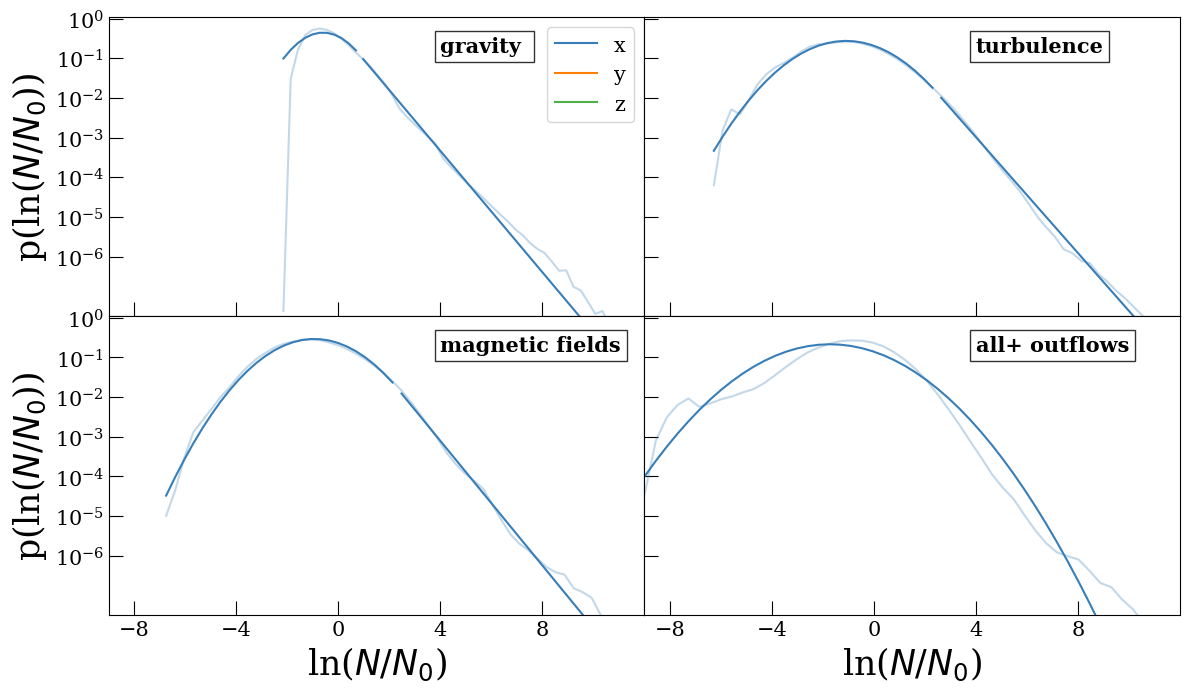

time: 0.037737830479939775


In [16]:
#power law fitting. 
start = time.time()
print('starting')
slopes = []
transit =[]
transit_error = []
error = []
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,8), sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})

ax =ax.ravel()
#plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
#ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)

ax[0].plot(100,100, color = '#377eb8', alpha =1)
ax[0].plot(100,100, color = '#ff7f00', alpha =1)
ax[0].plot(100,100, color = '#4daf4a', alpha =1)
ax[0].legend([ 'x', 'y', 'z'],fontsize =15)
b = 0

for n in range(4):
    den = plot_data[plot_data.files[n]]
    color_list = ('#377eb8', '#ff7f00', '#4daf4a')
    print(n)     #for time keeping
    
    for a in (range(1)):
        #load in  histrogram data, fully ready to plot
        bin_list = plot_data[plot_data.files[n]]
        counts = plot_data[plot_data.files[n+4]]
        
#######################################################################################
        #power fit specifics
        xdata = bin_list
        ydata = counts
        ydata = np.array(ydata)
        #p0= (sigma, alpha)
        p0=[.66, 3]
        print(len(xdata),len(ydata))


        #print(type(params))

        #print(ydata)
        params = Params(s_cut_off = 6) #cut off for x, the maximum value of x
        results = PLFit(xdata, ydata, p0, params)#, use_K21=True)
        y_int = .6
        sigma_limit = results.sg
        slope_limit = results.sg
        trans = results.sg
        trans_error = results.sg_err
        transit.append(trans)
        transit_error.append(trans_error)
        slope = results.alpha_g
        slopes.append(slope)
        sigma = results.sigma
        sigmas.append(sigma)
        slope_error = results.alpha_g_err
        slopes_error.append(slope_error)
        sigma_error = results.sigma_err
        sigmas_error.append(sigma_error)
#######################################################################################
        #create subrange and plots linear fit
        x =[]
        y = []
        x_log =[]
        y_log = []
        for i in range(len(bin_list)):
            if bin_list[i] > slope_limit:
                if counts[i] > 0:
                        x.append(bin_list[i])
                        y.append(counts[i])
                else:
                    break

        #create subrange and plots linear fit
        x =[]
        y = []
        x_log =[]
        y_log = []
        for i in range(len(bin_list)):
            if bin_list[i] > slope_limit:
                if counts[i] > 0:
                        x.append(bin_list[i])
                        y.append(counts[i])
                else:
                    break
        for i in range(len(bin_list)):
            if bin_list[i] < sigma_limit:
                    x_log.append(bin_list[i])
                    y_log.append(counts[i])
            else:
                break
                
        
        log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
        y_log = lognorm(np.array(x_log),results.s0,results.sigma)
        #find y intercept
        m = -1*results.alpha_g
        x_b = x_log[len(x_log)-1]
        y_b = y_log[len(y_log)-1]
        b_log =  y_b-(m*x_b)
        
        y = linear(np.array(x),m,b_log)

        
        ax[n].plot(x,np.exp(y), color = color_list[a])
        ax[n].plot(x_log,np.exp(y_log), color = color_list[a])

    
        ax[n].plot(bin_list, counts, color = color_list[a], alpha = .3)
        #ax[n].plot(x,np.exp(y), color = color_list[a])


        
    if n > 1:
        ax[n].set_xlabel(r'ln($N/N_0$)', size=25)
    if n == 0 or n == 2:
        ax[n].set_ylabel(r'p(ln($N/N_0$))', size=25)
    

    ax[n].annotate(titles[n], (4,.2), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))

    #ax[n].set_title(titles[n], size = 17)
    ax[n].tick_params(direction='in', length=6, size = 10, labelsize = 14)
    ax[n].set_yscale('log')
    ax[n].set_ylim(10**(-7.5),1.1)
    ax[n].set_xlim(-9,12)
    ax[n].tick_params(direction='in', length=10, labelsize = 15, which = 'major')

    ax[n].set_xticks((-8,-4,0,4,8))
    ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6))

plt.tight_layout()
plt.subplots_adjust(top=.85)
plt.savefig('plots/PLFit_vol_'+perc+'%.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

file = open("txt_file_storage/vol_power_fit_slope" +perc+"%.txt", "w")
str_dictionary = repr(slopes)
file.write(str_dictionary + "\n")
str_dictionary = repr(slopes_error)
file.write(str_dictionary + "\n")
file.close()

file = open("txt_file_storage/vol_power_fit_sigma" +perc+"%.txt", "w")
str_dictionary = repr(sigmas)
file.write(str_dictionary + "\n")
str_dictionary = repr(sigmas_error)
file.write(str_dictionary + "\n")
file.close()

file = open("txt_file_storage/vol_trans_density" +perc+"%.txt", "w")
str_dictionary = repr(transit)
file.write(str_dictionary + "\n")
str_dictionary = repr(transit_error)
file.write(str_dictionary + "\n")
file.close()

end = time.time()
print("time:",(end-start)/60)

In [18]:
slopes_error

[0.05356243742730918,
 0.07429784921117441,
 0.07028542763792829,
 244852.16214493546]

In [56]:
print(xdata)

[1.732955550744731e-19, 5.18426564517699e-19, 8.635575739609248e-19, 1.2086885834041508e-18, 1.5538195928473767e-18, 1.8989506022906025e-18, 2.2440816117338284e-18, 2.5892126211770543e-18, 2.9343436306202803e-18, 3.2794746400635062e-18, 3.624605649506732e-18, 3.969736658949958e-18, 4.314867668393184e-18, 4.65999867783641e-18, 5.0051296872796356e-18, 5.3502606967228615e-18, 5.6953917061660875e-18, 6.0405227156093134e-18, 6.385653725052539e-18, 6.730784734495765e-18, 7.075915743938991e-18, 7.421046753382216e-18, 7.766177762825443e-18, 8.111308772268668e-18, 8.456439781711895e-18, 8.80157079115512e-18, 9.146701800598347e-18, 9.491832810041571e-18, 9.836963819484799e-18, 1.0182094828928023e-17, 1.052722583837125e-17, 1.0872356847814475e-17, 1.1217487857257703e-17, 1.1562618866700927e-17, 1.1907749876144154e-17, 1.2252880885587379e-17, 1.2598011895030606e-17, 1.294314290447383e-17, 1.3288273913917058e-17, 1.3633404923360283e-17, 1.397853593280351e-17, 1.4323666942246735e-17, 1.4668797951689

In [57]:
ydata

array([2.89738999e+18, 3.83181464e+13, 9.64969660e+12, 4.23118687e+12,
       2.46099645e+12, 1.25208591e+12, 1.10097209e+12, 4.96516827e+11,
       5.61279891e+11, 4.10166075e+11, 1.72701505e+11, 2.80639946e+11,
       1.94289193e+11, 1.72701505e+11, 1.51113817e+11, 1.07938441e+11,
       1.07938441e+11, 1.51113817e+11, 0.00000000e+00, 1.07938441e+11,
       4.31753763e+10, 2.15876881e+10, 0.00000000e+00, 2.15876881e+10,
       6.47630644e+10, 4.31753763e+10, 0.00000000e+00, 2.15876881e+10,
       4.31753763e+10, 4.31753763e+10, 4.31753763e+10, 2.15876881e+10,
       0.00000000e+00, 0.00000000e+00, 2.15876881e+10, 4.31753763e+10,
       0.00000000e+00, 2.15876881e+10, 2.15876881e+10, 2.15876881e+10,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.15876881e+10, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.15876881e+10])

In [47]:
bins

array([4.48824949e-22, 2.24258185e-18, 4.48471488e-18, 6.72684791e-18,
       8.96898094e-18, 1.12111140e-17, 1.34532470e-17, 1.56953800e-17,
       1.79375130e-17, 2.01796461e-17, 2.24217791e-17, 2.46639121e-17,
       2.69060452e-17, 2.91481782e-17, 3.13903112e-17, 3.36324442e-17,
       3.58745773e-17, 3.81167103e-17, 4.03588433e-17, 4.26009763e-17,
       4.48431094e-17, 4.70852424e-17, 4.93273754e-17, 5.15695085e-17,
       5.38116415e-17, 5.60537745e-17, 5.82959075e-17, 6.05380406e-17,
       6.27801736e-17, 6.50223066e-17, 6.72644397e-17, 6.95065727e-17,
       7.17487057e-17, 7.39908387e-17, 7.62329718e-17, 7.84751048e-17,
       8.07172378e-17, 8.29593708e-17, 8.52015039e-17, 8.74436369e-17,
       8.96857699e-17, 9.19279030e-17, 9.41700360e-17, 9.64121690e-17,
       9.86543020e-17, 1.00896435e-16, 1.03138568e-16, 1.05380701e-16,
       1.07622834e-16, 1.09864967e-16, 1.12107100e-16])

In [40]:
bins = []
counts = []
for L in range(len(binS_d)):
    if binS_d[L] > 3:
        bins.append(binS_d[L])
        if L < 50:
            counts.append(counts_d[L])


In [36]:
arr = np.ones(4)
test = arr.tolist()
type(test)

list

In [46]:
len(ydata)

31

In [38]:
type(binS_d)

numpy.ndarray

In [42]:
type(np.array(bins))

numpy.ndarray